## Zaawansowane Metody Inteligencji Obliczeniowej
# Zadanie domowe 1
### Prowadzący: Michał Kempka, Marek Wydmuch
### Autor: Dariusz Max Adamski - 136674, 16:50

## Wprowadzenie

Całe zadanie jest oparte o różne wersje środowiska `FrozenLake` ze znanej biblioteki OpenAI Gym (https://gym.openai.com), która agreguje różnego rodzaju środowiska pod postacią jednego zunifikowanego API.

Zapoznaj się z opisem środowiska (https://gym.openai.com/envs/FrozenLake-v0) następnie zapoznaj się z kodem poniżej. Pokazuje on podstawy użytkowania API biblioteki Gym.

#### Uwaga: Możesz dowolnie modyfikować elementy tego notebooka (wstawiać komórki i zmieniać kod) o ile nie napisano gdzieś inaczej.

In [5]:
# Zaimportuj środowisko FrozenLake z OpenAI Gym
from gym.envs.toy_text.frozen_lake import FrozenLakeEnv, generate_random_map
from pprint import pprint

# Stwórzmy deterministyczne (`is_slippper=False`) środowisko w oparciu o jedną z zpredefiniowanych map (`map_name="4x4"`)
env = FrozenLakeEnv(map_name="4x4", is_slippery=False) 

# Po stworzeniu środowiska musimy je zresetować 
env.reset()
# W każdym momencie możemy wyświetlić stan naszego środowiska przy użyciu fukcji `render`
env.render()


SFFF
FHFH
FFFH
HFFG


## Zad 1 - Policy iteration + value iteration (10 pkt)

W komórkach poniżej zaimplementuj algorytmy **iteracji polityki** oraz **iteracji wartości**, wyznaczające deterministyczną politykę dla środowiska FrozenLake.

Odpowiedź na pytania wykonując odpowiednie eksperymenty (zostaw output odpowiednich komórek na poparcie swoich twierdzeń):
- Jak zmiana współczynniku `gamma` wpływa na wynikową politykę?
- Jak stochastyczność wpływa na liczbę iteracji potrzebnych do zbiegnięcia obu algorytmów oraz wynikową politykę?

#### Uwaga: nie zmieniaj nazwy funkcji `policy_iteration` i `value_iteration`, ani ich argumentów. Nie dopisuj do komórek z funkcjami innego kodu. Może zdefiniować funkcje pomocnicze dla danej funkcji w tej samej komórce.

1. Dla deterministycznego środowiska gamma nie miała znaczenia. Dla niederministycznego, średnia nagroda była mniejsza dla mniejszych gamma.
2. Stochastyczność sprawia, że liczba iteracji potrzebnych do zbiegnięcia rośnie. Dodatkowo w niedeterministycznym środowisku dla  większych gamma, ilość potrzebnych iteracji szybko rośnie. W badanym przypadku, dla deterministycznego środowiska ilośc iteracji powoli rośnie z gamma do pewnego punktu ($\gamma \approx 0.5$), a dla większych wartości jest stała.

Wnioski bazują na poniższym wykresie.

In [2]:
from numpy import argmax

def policy_iteration(P, gamma, delta=0.001):
    """
    Argumenty:
        P - model przejścia, gdzie P[s][a] == [(prawdopodobieństwo, kolejny stan, nagroda, czy stan terminalny), ...]
        gamma - współczynnik dyskontujący
        delta - tolerancja warunku stopu
    Zwracane wartości:
        V - lista o długości len(P) zawierający oszacowane wartość stanu s: V[s]
        pi - lista o długości len(P) zawierający wyznaczoną deterministyczną politykę - akcję dla stanu s: pi[s]
        i - ilość iteracji algorytmu po wszystkich stanach
    """
    γ, Δmin = gamma, delta
    V = [0.0] * len(P)
    π = [0] * len(P)
    i = 0
    
    while True:
        while True:
            i += 1
            Δ = 0
            for s in P:
                v = V[s]
                V[s] = sum(p*(r + γ*V[s_next]) for p, s_next, r, _ in P[s][π[s]])
                Δ = max(Δ, abs(v - V[s]))
            if Δ < Δmin:
                break

        stop = True
        for s in P:
            a = π[s]
            π[s] = argmax([ sum(p*(r + γ*V[s_next]) for p, s_next, r, _ in P[s][a]) for a in P[s] ])
            if a != π[s]:
                stop = False
                
        if stop:
            break
            
    return V, π, i

In [9]:
from numpy import argmax

def value_iteration(P, gamma, delta=0.001):
    """
    Argumenty:
        P - model przejścia, gdzie P[s][a] == [(prawdopodobieństwo, kolejny stan, nagroda, czy stan terminalny), ...]
        gamma - współczynnik dyskontujący
        delta - tolerancja warunku stopu
    Zwracane wartości:
        Q - lista o długości len(P) zawierający listy z oszacowanymi wartościami dla stanu s i akcji a: Q[s][a]
        pi - lista o długości len(P) zawierający wyznaczoną deterministyczną politykę - akcję dla stanu s: pi[s]
        i - ilość iteracji algorytmu po wszystkich stanach
    """
    γ, Δmin = gamma, delta
    Q = [[0.0] * len(P[s]) for s in P]
    V = [0.0] * len(P)
    π = [0] * len(P)
    i = 0
    
    while True:
        i += 1
        Δ = 0
        for s in P:
            v = V[s]
            V[s] = max([ sum(p*(r + γ*V[s_next]) for p, s_next, r, _ in P[s][a]) for a in P[s] ])
            for a in P[s]:
                Q[s][a] = sum(p*(r + γ*max(Q[s_next])) for p, s_next, r, _ in P[s][a])
            Δ = max(Δ, abs(v - V[s]))
        if Δ < Δmin:
            break
            
    for s in P:
        π[s] = argmax([ sum(p*(r + γ*V[s_next]) for p, s_next, r, _ in P[s][a]) for a in P[s] ])
    
    return Q, π, i

In [6]:
# Wprowadzmy teraz funkcję, które empirycznie zewauluje naszą politykę
# po prostu rozgrywając odpowiednią liczbę episodów zgodnie z naszą polityką.
def evaluate_empirically(env, pi, episodes=1000, max_actions=100):
    total_rs = []
    for e in range(episodes):
        s = env.reset()
        total_r = 0
        for _ in range(max_actions): # Na wypadek polityki, która nigdy nie dojdzie od stanu terminalnego
            s, r, final, _ = env.step(pi[s])
            total_r += r
            if final:
                break
        total_rs.append(total_r)
    return np.mean(total_rs)       

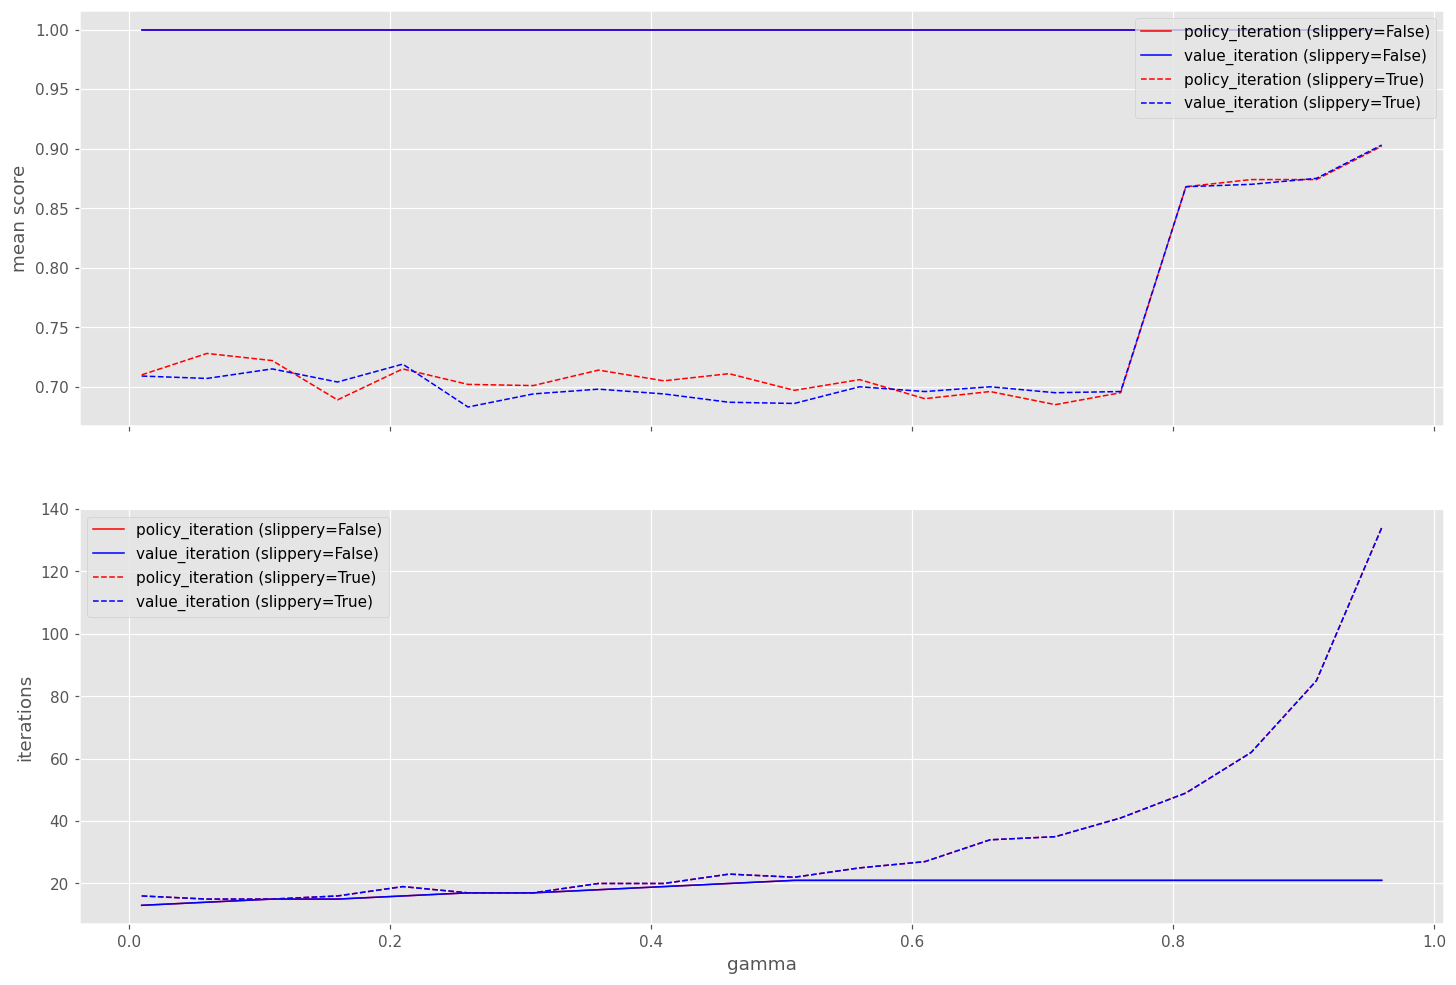

In [6]:
import numpy as np
import matplotlib.pyplot as plt

lake_map = generate_random_map(size=6)
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
gammas = np.arange(0.01, 1, 0.05)

for line, slippery in [('-', False), ('--',True)]:
    env = FrozenLakeEnv(desc=lake_map, is_slippery=slippery) 
    for color, func in [('r',policy_iteration), ('b',value_iteration)]:
        scores, iters = [], []
        for gamma in gammas:
            score, iter = 0, 0
            for _ in range(10):
                _, pi, i = policy_iteration(env.P, gamma)
                s = evaluate_empirically(env, pi)
                if s > score:
                    score, iter = s, i
                    if not slippery: break
            scores.append(score)
            iters.append(iter)
        ax1.plot(gammas, scores, ls=line, color=color, label=f'{func.__name__} (slippery={slippery})')
        ax2.plot(gammas, iters, ls=line, color=color, label=f'{func.__name__} (slippery={slippery})')
        
ax1.set_ylabel('mean score')
ax2.set_ylabel('iterations')
ax2.set_xlabel('gamma')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.show()

## Zad 2 - Monte Carlo (10 pkt)
W komórce poniżej zaimplementuj metodę **On-policy Monte Carlo** dla polityki epsilon-greedy.
Zakładamy, że model przejść nie jest w tym wypadku dla nas dostępny,
dlatego możesz używać wyłącznie metod `env.reset()` i `env.step()`
w swojej implementacji, w celu wygenerowania nowego epizodu.

- Zaproponuj warunek stopu dla swojej implementacji.
- Jaki jest wpływ epsilony na działanie algorytmu?
- Jaka prosta modyfikacja nagród środowiska przyśpieszyłaby odkrywanie dobrej polityki? Zmodyfikuj env.P i zademonstruj. 

Tip: z racji, że env.P jest dostępne, możesz porównać wyniki `on_policy_eps_greedy_monte_carlo` ze wynikami `value_iteration`. 

#### Uwaga: nie zmieniaj nazwy funkcji `on_policy_eps_greedy_monte_carlo`, ani jej pierwszych argumentów (możesz dodać nowe argumenty z wartościami domyślnymi). Nie dopisuj do komórki z funkcją innego kodu. Może zdefiniować funkcje pomocnicze dla funkcji w tej samej komórce.

1. Po pierwsze, sprawdzam czy czas wykonania nie przekroczył maksimum `timeout`. Po drugie, założyłem, żeby algorytm się kończył jeśli suma elementów tablicy $Q$ nie zwiększyła się o co najmniej `min_improvement` po `patience` iteracjach.
2. Przy małym epsilonie algorytm nie zbiega w wyznaczonym czasie, ponieważ prawdopodobieństwo losowej eksploracji jest zbyt małe. Przy zbyt dużym epsilonie algorytm znajduje mierne polityki, bo działa zbyt losowo. Przy epsilonie bliskim 0.5 algorytm znajduje czasami dobre polityki. Ogólnie, problemem w tym podejściu jest stały epsilon. Może zmniejszanie epsilona co którąś iterację by pomogło na początku wyszukać dostateczną politykę, a później ją systematycznie ulepszać.
3. Dla przejść, które prowadzą do dziury można ustawić nagrodę $r$ na ujemną wartość np. -1. W poniższym eksperymencie widać, że dla zmodyfikowanego środowiska znajduje politykę z 3 razy lepszą średnią nagrodą, na co potrzebuje 3 razy mniej iteracji.

In [75]:
from time import time
import numpy as np

def gen_episode(env, π, max_actions=50):
    ep, rs = [], []
    s = env.reset()
    for i in range(max_actions):
        a = np.random.choice(np.arange(len(π[s])), 1, p=π[s])[0]
        s_next, r, term, _ = env.step(a)
        ep.append((s, a))
        rs.append(r)
        if term: break
        s = s_next
    return ep, rs

def on_policy_eps_greedy_monte_carlo(env, eps, gamma, timeout=5*60, patience=10_000, min_improvement=0.0001, plot_history=False):
    """
    Argumenty:
        env - środowisko implementujące metody `reset()` oraz `step(action)`
        eps - współczynnik eksploracji
        gamma - współczynnik dyskontujący
        timeout - maksymalny czas wykonania - domyślnie 10 minut
        patience - maksymalna licza iteracji podczas których żaden element Q się nie zwiększa
    Zwracane wartości:
        Q - lista o długości len(P) zawierający listy z oszacowanymi wartościami dla stanu s i akcji a: Q[s][a]
        pi - lista o długości len(P) zawierający wyznaczoną deterministyczną (zachłanną) politykę - akcję dla stanu s: pi[s]
        i - ilość epizodów wygenerowanych przez algorytm
    """
    ϵ, γ = eps, gamma
    Q = [[0 for a in env.P[s]] for s in env.P]
    G = [[0 for a in env.P[s]] for s in env.P]
    N = [[0 for a in env.P[s]] for s in env.P]
    π = np.array([[1/len(env.P[s]) for a in env.P[s]] for s in env.P])
    π_best = π.copy()
    since_improvement = 0
    best_q = None
    
    i = 0
    start_time = time()
    while time() - start_time < timeout and since_improvement < patience:
        ep, rs = gen_episode(env, π)
        g = 0
        i += 1
        for t in range(len(ep)-1, -1, -1):
            (s, a), r = ep[t], rs[t]
            g = γ*g + r
            if (s, a) not in ep[:t]:
                G[s][a] += g
                N[s][a] += 1
                Q[s][a] = G[s][a] / N[s][a]
                A_star = np.argmax(Q[s])
                A = env.P[s]
                π[s][:] = ϵ/len(A)
                π[s][A_star] += 1 - ϵ
                        
        since_improvement += 1
        total_q = np.sum(Q)
        if best_q is None or total_q - best_q > min_improvement:
            since_improvement = 0
            best_q = total_q
            history.append([i, total_q])
            π_best = π
                
    return Q, list(np.argmax(π_best, axis=1)), i

In [63]:
lake_map = generate_random_map(size=6)

ϵ	score	iters	time
0.10	0.0	10001	16.35
0.15	0.0	10001	16.04
0.20	0.0	10001	15.66
0.25	0.339	18119	18.76
0.30	0.135	26000	22.27
0.35	0.221	47360	39.08
0.40	0.272	24464	21.57
0.45	0.17	12981	11.05
0.50	0.238	15484	13.96
0.55	0.799	31596	25.47
0.60	0.138	11489	9.41
0.65	0.131	12035	9.45
0.70	0.166	10123	8.22
0.75	0.12	10444	8.36
0.80	0.39	11984	10.43
0.85	0.148	13087	10.75


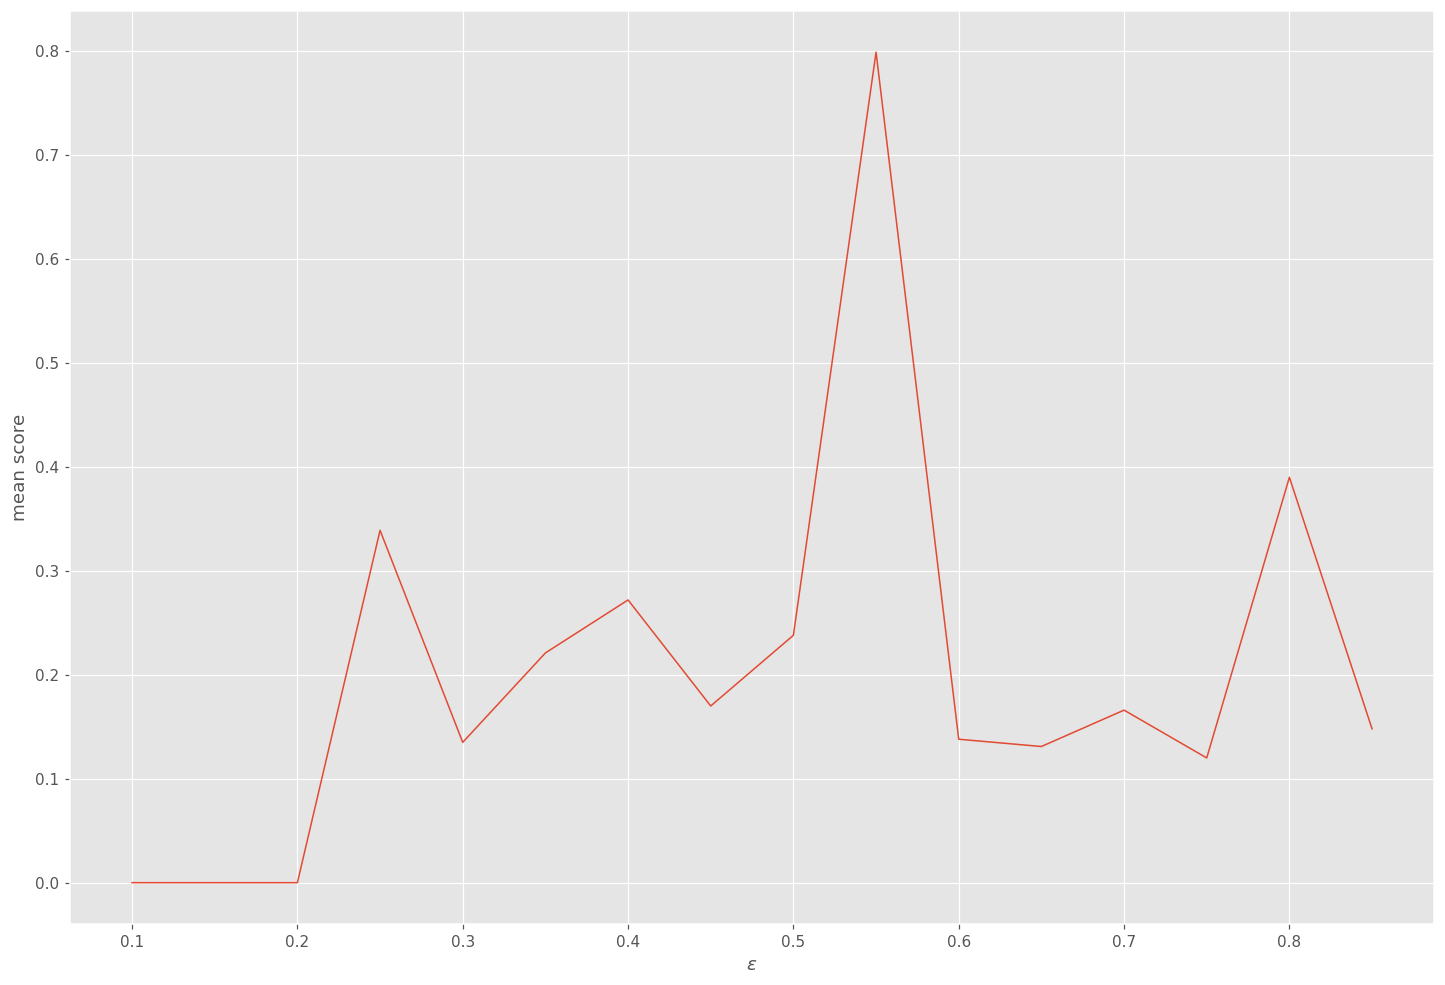

In [73]:
def inspect_epsilons():
    xs = np.arange(0.1, 0.9, 0.05)
    ys = []
    results = []
    print('ϵ\tscore\titers\ttime')
    for eps in xs:
        t = time()
        Q, pi, iters = on_policy_eps_greedy_monte_carlo(env1, eps=eps, gamma=0.6, timeout=60, patience=10_000, plot_history=False)
        res = evaluate_empirically(env1, pi)
        print(f'{eps:.2f}\t{res}\t{iters}\t{time() - t:.2f}')
        ys.append(res)
        
    plt.plot(xs, ys)
    plt.xlabel('$\epsilon$')
    plt.ylabel('mean score')

In [76]:
env1 = FrozenLakeEnv(desc=lake_map, is_slippery=True) 
env2 = FrozenLakeEnv(desc=lake_map, is_slippery=True) 
env3 = FrozenLakeEnv(desc=lake_map, is_slippery=False) 
env1.render()

for s in env2.P:
    for a in env2.P[s]:
        for i, (p, s_next, r, term) in enumerate(env2.P[s][a]):
            if p < 1 and term and r != 1:
                env2.P[s][a][i] = (p, s_next, -1, term)
                

for name, env, test_env in [('ORIGINAL ENV', env1, env1), ('MODIFIED ENV', env2, env1), ('DETERMINISTIC ENV', env3, env3)]:
    print('\n----------------\n'+name)
    Q, pi, iters = value_iteration(env.P, gamma=0.9)
    res = evaluate_empirically(test_env, pi)
    print('\nVALUE ITERATION')
    print('iters  =', iters)
    print('result =', res)

    Q, pi, iters = on_policy_eps_greedy_monte_carlo(env, eps=0.5, gamma=0.6, timeout=3*60, patience=10_000)
    res = evaluate_empirically(test_env, pi)
    print('\nEPS-GREEDY MONTE CARLO')
    print('iters  =', iters)
    print('result =', res)


SFFFFH
FFHFFF
FFHFFF
FFFFFF
FFFFHF
FFFFFG

----------------
ORIGINAL ENV

VALUE ITERATION
iters  = 26
result = 0.935

EPS-GREEDY MONTE CARLO
iters  = 30171
result = 0.255

----------------
MODIFIED ENV

VALUE ITERATION
iters  = 26
result = 0.946

EPS-GREEDY MONTE CARLO
iters  = 10001
result = 0.793

----------------
DETERMINISTIC ENV

VALUE ITERATION
iters  = 11
result = 1.0

EPS-GREEDY MONTE CARLO
iters  = 142824
result = 1.0
